### How movies evolve over time?

In [1]:
import pandas as pd
import numpy as np

In [2]:
movies = pd.read_csv('./movielens-20m-dataset/movie.csv')
#rating = pd.read_csv('./movielens-20m-dataset/rating.csv')
#tag = pd.read_csv('./movielens-20m-dataset/tag.csv')

In [3]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


### Extract Title and Year

title columns consist of movie title following by year of release in the blanket

In [4]:
import re
movies['title_format'] = movies['title'].apply(lambda x: re.search('\(\d+\)',x))

In [5]:
movies.head()

,movieId,title,genres,title_format
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,<_sre.SRE_Match object at 0x10ef309f0>
1,2,Jumanji (1995),Adventure|Children|Fantasy,<_sre.SRE_Match object at 0x10ef30a58>
2,3,Grumpier Old Men (1995),Comedy|Romance,<_sre.SRE_Match object at 0x10ef30ac0>
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,<_sre.SRE_Match object at 0x10ef30b28>
4,5,Father of the Bride Part II (1995),Comedy,<_sre.SRE_Match object at 0x10ef30b90>


However, regular expression does not find this format in some rows

In [6]:
movies[movies['title_format'].isnull()]

,movieId,title,genres,title_format
10593,40697,Babylon 5,Sci-Fi,None
15646,79607,"Millions Game, The (Das Millionenspiel)",Action|Drama|Sci-Fi|Thriller,None
17341,87442,"Bicycle, Spoon, Apple (Bicicleta, cullera, poma)",Documentary,None
22368,107434,Diplomatic Immunity (2009– ),Comedy,None
22669,108548,"Big Bang Theory, The (2007-)",Comedy,None
22679,108583,Fawlty Towers (1975-1979),Comedy,None
23617,112406,Brazil: In the Shadow of the Stadiums,Documentary,None
23824,113190,Slaying the Badger,Documentary,None
24286,115133,Tatort: Im Schmerz geboren,Crime,None
24412,115685,National Theatre Live: Frankenstein,Drama|Fantasy,None


Remove from list movies with no release year

In [7]:
# Remove from list movies with no release year
movies = movies[movies['title_format'].isnull()==False]

In [8]:
movies.shape

(27256, 4)

Using regular expression, extract movies' title names and released year

In [9]:
movies['title_name'] = movies['title'].apply(lambda x: x[:re.search('\(\d+\)',x).start()])
movies['year'] = movies['title'].apply(lambda x: re.search('\(\d+\)',x).group(0))
movies['released_year'] = movies['year'].apply(lambda x: re.search('\d+',x).group())

In [10]:
movies.head()

,movieId,title,genres,title_format,title_name,year,released_year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,<_sre.SRE_Match object at 0x10ef309f0>,Toy Story,(1995),1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,<_sre.SRE_Match object at 0x10ef30a58>,Jumanji,(1995),1995
2,3,Grumpier Old Men (1995),Comedy|Romance,<_sre.SRE_Match object at 0x10ef30ac0>,Grumpier Old Men,(1995),1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,<_sre.SRE_Match object at 0x10ef30b28>,Waiting to Exhale,(1995),1995
4,5,Father of the Bride Part II (1995),Comedy,<_sre.SRE_Match object at 0x10ef30b90>,Father of the Bride Part II,(1995),1995


### Explore movies by year of release

In [11]:
movies_by_year = movies['released_year'].value_counts().reset_index()
movies_by_year.columns = ['released_year','number_of_movies']
movies_by_year = movies_by_year.sort_values(by='released_year')

In [12]:
movies_by_year

,released_year,number_of_movies
112,06,1
111,1891,1
120,1893,1
107,1894,2
108,1895,2
109,1896,2
102,1898,5
110,1899,1
116,1900,1
115,1901,1


Remove year with uncommon value (i.e. 06, 500, 69) from the dataframe

In [13]:
movies.shape, movies_by_year.shape

((27256, 7), (121, 2))

In [14]:
movies = movies[movies.released_year.isin(['06','500','69'])==False]
movies_by_year = movies_by_year[movies_by_year.isin(['06','500','69'])==False]

In [15]:
movies.shape, movies_by_year.shape

((27253, 7), (121, 2))

Plot number of movies by released year

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117]),
 <a list of 118 Text xticklabel objects>)

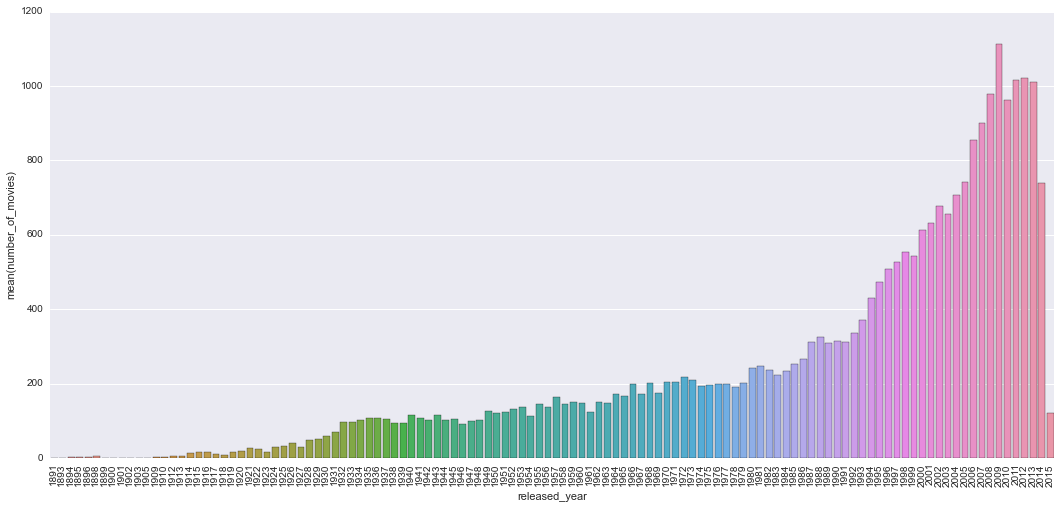

In [17]:
plt.rcParams['figure.figsize'] = (18, 8)
ax = sns.barplot(movies_by_year.released_year, movies_by_year.number_of_movies)
plt.xticks(rotation=90)

We can see that the number of movies grew more significantly from 1990

### Extract Genre
Genre list are stored in Genre field by list separated by '|'
Using pandas get_dummies function to split this list into dummy code

In [18]:
movies_genre = movies.genres.str.get_dummies('|')

In [19]:
movies_genre.head()

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Merge Genre list into original dataframe

In [20]:
df_movies = pd.merge(movies, movies_genre, how='inner', left_index=True, right_index=True)

In [21]:
df_movies.head()

,movieId,title,genres,title_format,title_name,year,released_year,(no genres listed),Action,Adventure,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,<_sre.SRE_Match object at 0x10ef309f0>,Toy Story,(1995),1995,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,<_sre.SRE_Match object at 0x10ef30a58>,Jumanji,(1995),1995,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,<_sre.SRE_Match object at 0x10ef30ac0>,Grumpier Old Men,(1995),1995,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,<_sre.SRE_Match object at 0x10ef30b28>,Waiting to Exhale,(1995),1995,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,<_sre.SRE_Match object at 0x10ef30b90>,Father of the Bride Part II,(1995),1995,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Let's see how many movies do not have any genre

In [22]:
df_movies[df_movies['(no genres listed)']==1]

,movieId,title,genres,title_format,title_name,year,released_year,(no genres listed),Action,Adventure,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
16574,83773,Away with Words (San tiao ren) (1999),(no genres listed),<_sre.SRE_Match object at 0x10ec82b90>,Away with Words (San tiao ren),(1999),1999,1,0,0,...,0,0,0,0,0,0,0,0,0,0
16589,83829,Scorpio Rising (1964),(no genres listed),<_sre.SRE_Match object at 0x10ec83238>,Scorpio Rising,(1964),1964,1,0,0,...,0,0,0,0,0,0,0,0,0,0
16764,84768,Glitterbug (1994),(no genres listed),<_sre.SRE_Match object at 0x10ec87b90>,Glitterbug,(1994),1994,1,0,0,...,0,0,0,0,0,0,0,0,0,0
17080,86493,"Age of the Earth, The (A Idade da Terra) (1980)",(no genres listed),<_sre.SRE_Match object at 0x10ec90100>,"Age of the Earth, The (A Idade da Terra)",(1980),1980,1,0,0,...,0,0,0,0,0,0,0,0,0,0
17243,87061,Trails (Veredas) (1978),(no genres listed),<_sre.SRE_Match object at 0x10ec94578>,Trails (Veredas),(1978),1978,1,0,0,...,0,0,0,0,0,0,0,0,0,0
18246,91246,Milky Way (Tejút) (2007),(no genres listed),<_sre.SRE_Match object at 0x10ecaeb28>,Milky Way (Tejút),(2007),2007,1,0,0,...,0,0,0,0,0,0,0,0,0,0
18566,92435,"Dancing Hawk, The (Tanczacy jastrzab) (1978)",(no genres listed),<_sre.SRE_Match object at 0x10ecb7238>,"Dancing Hawk, The (Tanczacy jastrzab)",(1978),1978,1,0,0,...,0,0,0,0,0,0,0,0,0,0
18606,92641,Warsaw Bridge (Pont de Varsòvia) (1990),(no genres listed),<_sre.SRE_Match object at 0x10efce308>,Warsaw Bridge (Pont de Varsòvia),(1990),1990,1,0,0,...,0,0,0,0,0,0,0,0,0,0
18984,94431,"Ella Lola, a la Trilby (1898)",(no genres listed),<_sre.SRE_Match object at 0x10efd8238>,"Ella Lola, a la Trilby",(1898),1898,1,0,0,...,0,0,0,0,0,0,0,0,0,0
19015,94657,"Turkish Dance, Ella Lola (1898)",(no genres listed),<_sre.SRE_Match object at 0x10efd8ed0>,"Turkish Dance, Ella Lola",(1898),1898,1,0,0,...,0,0,0,0,0,0,0,0,0,0


### Plot number of movies by genre over time
Let's look at some selected genres

In [23]:
genre_list = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime',
              'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX',
              'Musical','Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
year_genre_movies = df_movies.groupby(['released_year'])[genre_list].sum()

In [24]:
year_genre_movies.head()

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
released_year,,,,,,,,,,,,,,,,,,,
1891,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1893,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1894,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
1895,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1896,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0


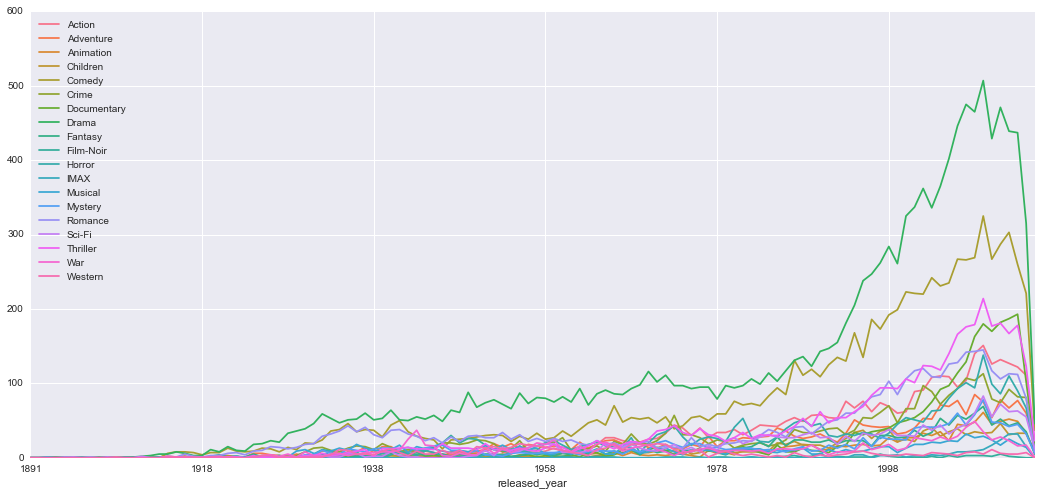

In [25]:
#sns.palplot(sns.color_palette("hls", 8))
sns.set_palette(sns.color_palette("husl",len(genre_list)))
ax = year_genre_movies.plot()

In [26]:
for genre in genre_list:
    print genre + ': ' + str(year_genre_movies[genre].sum())

Action: 3519
Adventure: 2329
Animation: 1027
Children: 1139
Comedy: 8368
Crime: 2938
Documentary: 2467
Drama: 13337
Fantasy: 1411
Film-Noir: 330
Horror: 2611
IMAX: 196
Musical: 1035
Mystery: 1513
Romance: 4125
Sci-Fi: 1741
Thriller: 4177
War: 1194
Western: 676


Let's look at only major genres

In [27]:
genre_list = ['Action', 'Adventure', 'Animation', 'Comedy', 'Crime',
              'Drama', 'Fantasy', 'Horror', 
              'Mystery', 'Romance', 'Sci-Fi', 'Thriller']
year_genre_movies = df_movies.groupby(['released_year'])[genre_list].sum()

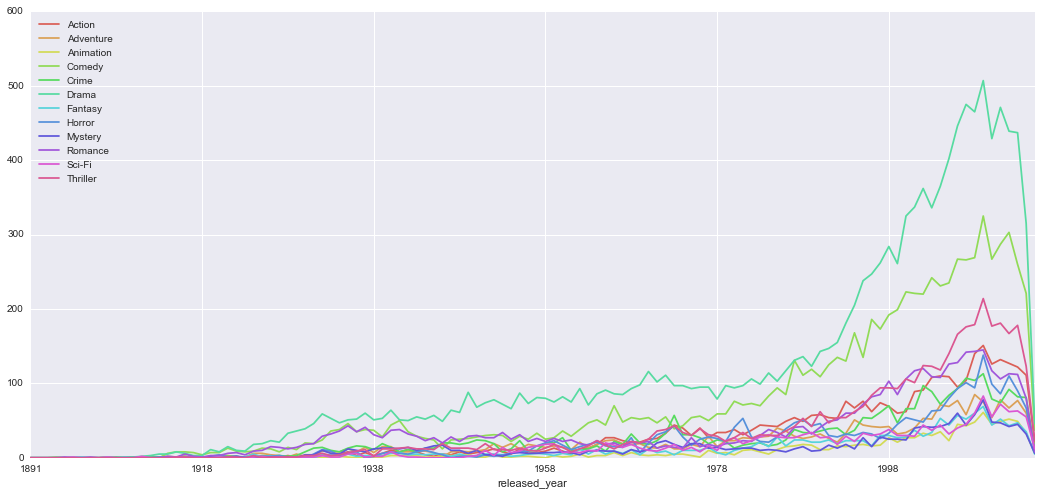

In [28]:
sns.set_palette(sns.color_palette("hls",len(genre_list)))
ax = year_genre_movies.plot()

In [29]:
year_genre_movies['Action'].sum()

3519

### Which genres receive the highest ratings? How does this change over time?
### Determine the temporal trends in the genres/tagging activity of the movies released

#### Load Rating dataset

In [30]:
rating = pd.read_csv('./movielens-20m-dataset/rating.csv')

In [31]:
rating.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [32]:
rating.shape

(20000263, 4)

In [33]:
df_movies.head()

,movieId,title,genres,title_format,title_name,year,released_year,(no genres listed),Action,Adventure,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,<_sre.SRE_Match object at 0x10ef309f0>,Toy Story,(1995),1995,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,<_sre.SRE_Match object at 0x10ef30a58>,Jumanji,(1995),1995,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,<_sre.SRE_Match object at 0x10ef30ac0>,Grumpier Old Men,(1995),1995,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,<_sre.SRE_Match object at 0x10ef30b28>,Waiting to Exhale,(1995),1995,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,<_sre.SRE_Match object at 0x10ef30b90>,Father of the Bride Part II,(1995),1995,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Average movie rating

In [34]:
average_rating = rating.groupby('movieId')['rating'].mean()

In [35]:
average_rating.head()

movieId
1    3.921240
2    3.211977
3    3.151040
4    2.861393
5    3.064592
Name: rating, dtype: float64

In [36]:
average_rating.shape

(26744,)

In [37]:
average_rating = average_rating.reset_index()

In [38]:
average_rating.head()

,movieId,rating
0,1,3.921240
1,2,3.211977
2,3,3.151040
3,4,2.861393
4,5,3.064592


In [39]:
df_movies.shape

(27253, 27)

In [40]:
df_movies_rating = pd.merge(df_movies, average_rating, how='left', on='movieId')

In [41]:
df_movies_rating.shape

(27253, 28)

In [43]:
df_movies_rating.head()

,movieId,title,genres,title_format,title_name,year,released_year,(no genres listed),Action,Adventure,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,<_sre.SRE_Match object at 0x10ef309f0>,Toy Story,(1995),1995,0,0,1,...,0,0,0,0,0,0,0,0,0,3.921240
1,2,Jumanji (1995),Adventure|Children|Fantasy,<_sre.SRE_Match object at 0x10ef30a58>,Jumanji,(1995),1995,0,0,1,...,0,0,0,0,0,0,0,0,0,3.211977
2,3,Grumpier Old Men (1995),Comedy|Romance,<_sre.SRE_Match object at 0x10ef30ac0>,Grumpier Old Men,(1995),1995,0,0,0,...,0,0,0,0,1,0,0,0,0,3.151040
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,<_sre.SRE_Match object at 0x10ef30b28>,Waiting to Exhale,(1995),1995,0,0,0,...,0,0,0,0,1,0,0,0,0,2.861393
4,5,Father of the Bride Part II (1995),Comedy,<_sre.SRE_Match object at 0x10ef30b90>,Father of the Bride Part II,(1995),1995,0,0,0,...,0,0,0,0,0,0,0,0,0,3.064592


#### Average rating by genre

In [44]:
for genre in genre_list:
    print genre, 'rating: ', df_movies_rating[df_movies_rating[genre]==1].rating.mean(), 'number of movies: ', \
          len(df_movies_rating[df_movies_rating[genre]==1])

Action rating:  2.97683354086 number of movies:  3519
Adventure rating:  3.07240749419 number of movies:  2329
Animation rating:  3.17709521251 number of movies:  1027
Comedy rating:  3.07418201523 number of movies:  8368
Crime rating:  3.16685282624 number of movies:  2938
Drama rating:  3.2620628153 number of movies:  13337
Fantasy rating:  3.09308425427 number of movies:  1411
Horror rating:  2.69679576528 number of movies:  2611
Mystery rating:  3.13499663245 number of movies:  1513
Romance rating:  3.2055452952 number of movies:  4125
Sci-Fi rating:  2.88951055437 number of movies:  1741
Thriller rating:  3.01606878534 number of movies:  4177


## Collaborative Filtering Recommendation System

In [45]:
rating.shape

(20000263, 4)